In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Module
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
import zipfile
import csv
from collections import OrderedDict
from PIL import Image

BATCH_SIZE = 40   

print(os.getcwd()) #获取当前工作目录路径

#解压缩文件
extracting = zipfile.ZipFile('train_val.zip')
extracting.extractall()


/content


In [0]:
def rotation(array, angle):
    X = np.rot90(array, angle[0], axes=(0, 1))  # rotate in X-axis
    Y = np.rot90(X, angle[1], axes=(0, 2))  # rotate in Y'-axis
    Z = np.rot90(Y, angle[2], axes=(1, 2))  # rotate in Z"-axis
    return Z


def reflection(array, axis):
    if axis != -1:
        ref = np.flip(array, axis)
    else:
        ref = np.copy(array)
    return ref


def crop(array, zyx, dhw):
    cropped = array[zyx - dhw // 2:zyx + dhw // 2,
             zyx - dhw // 2:zyx + dhw // 2,
             zyx - dhw // 2:zyx + dhw // 2]
    return cropped

# 加入旋转翻折等操作的数据处理
class Transform1(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        # shape = image.shape
        arr_ret = crop(image, 50, self.size)
        angle = np.random.randint(4, size=3)
        arr_ret = rotation(arr_ret, angle=angle)
        axis = np.random.randint(4) - 1
        arr_ret = reflection(arr_ret, axis=axis)
        arr_ret = np.expand_dims(arr_ret, axis=0)
        arr_ret = 2*arr_ret/255-1
        return {'image': (torch.from_numpy(arr_ret)).float(),
             'label': torch.tensor(label)}

# 简单数据处理
class Transform2(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        image = 2*image/255-1
        image = crop(image, 50, self.size)
        image = image[np.newaxis, ...] 
        return {'image': (torch.from_numpy(image)).float(),
             'label': torch.tensor(label)}

In [0]:
# 定义TrainDataset类， 继承Dataset, 重写抽象方法：__len()__, __getitem()__
class TrainDataset(Dataset):

    def __init__(self, root, names_file, crop_size=32, transform=None):
        self.root = root
        self.names_file = names_file
        self.transform = transform
        self.size = 0
        self.crop_size = crop_size
        self.names_list = []

        if not os.path.isfile(self.names_file):
            print(self.names_file + 'does not exist!')
        file = open(self.names_file)
        next(file)
        for f in file:
            self.names_list.append(f)
            self.size += 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        image_path = self.names_list[idx].split(',')[0]
        data = np.load(os.path.join(self.root, '%s.npz' % image_path))
        voxel = data['voxel']
        label = int(self.names_list[idx].split(',')[1])

        sample = {'image': voxel, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

# 变换ToTensor
class ToTensor(object):
    def __call__(self, sample):
        return {'image': torch.from_numpy(sample['image']),
             'label': torch.tensor(sample['label'])}

train_dataset = TrainDataset(root='train_val', names_file='train1.csv',transform=Transform2(32))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,drop_last=True)

In [0]:
class FeatureBlock(nn.Sequential):
    def __init__(self, input_channels, output_channels):
        super(FeatureBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        # add_module:在现有model中增添子module
        self.add_module('conv0', nn.Conv3d(input_channels, output_channels, kernel_size=3, stride=1, padding=0, bias=False)),
        self.add_module('norm0', nn.BatchNorm3d(output_channels)),
        self.add_module('relu0', nn.ReLU(inplace=True))

class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Bottleneck, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.add_module('conv', nn.Conv3d(in_channels, out_channels, kernel_size=1, bias=False))
        self.add_module('norm', nn.BatchNorm3d(num_features=out_channels))
        self.add_module('relu', nn.ReLU(inplace=True))

class DenseLayer(nn.Sequential):
    def __init__(self, input_channels, growth_rate, bn_size, bottleneck_ratio, drop_rate):   
        super(DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(input_channels)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv3d(input_channels, bn_size*growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),

        if bottleneck_ratio >0:
          self.add_module('bottleneck', Bottleneck(bn_size * growth_rate, bottleneck_ratio * growth_rate))
          in_channels = bottleneck_ratio * growth_rate
        else:
          in_channels = bn_size * growth_rate

        self.add_module('conv2', nn.Conv3d(in_channels, growth_rate,kernel_size=3, stride=1, padding=1, bias=False)),

        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate)
        return torch.cat([x, new_features], 1)


class DenseBlock(nn.Sequential):
    def __init__(self, num_layers, input_channels, bn_size, growth_rate, bottleneck_ratio, drop_rate):
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = DenseLayer(input_channels + i * growth_rate, growth_rate, bn_size, bottleneck_ratio, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class Transition(nn.Sequential):
    def __init__(self, input_channels, output_channels):
        super(Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm3d(input_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv3d(input_channels, output_channels, kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))

class Flatten(Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class Classification(nn.Sequential):

    def __init__(self, input_channels, output_classes):
        super(Classification, self).__init__()

        self.input_channels = input_channels
        self.output_classes = output_classes

        self.add_module('norm', nn.BatchNorm3d(num_features=input_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('pool', nn.AvgPool3d(kernel_size=7, stride=1))
        self.add_module('flatten', Flatten())
        self.add_module('linear', nn.Linear(input_channels, output_classes))


class DenseNet(nn.Module):
    def __init__(self, growth_rate=16, block_config=(4, 4, 4),
                 num_features=32, bn_size=4, bottleneck_ratio=0, drop_rate=0, num_classes=2):
        super(DenseNet, self).__init__()
        
        # 预处理
        self.features = FeatureBlock(input_channels=1,output_channels=num_features)

        # DenseBlock模块
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers=num_layers, input_channels=num_features,
                       bn_size=bn_size, growth_rate=growth_rate, bottleneck_ratio=bottleneck_ratio, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % i, block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(input_channels=num_features, output_channels=num_features // 2)
                self.features.add_module('transition%d' % i, trans)
                num_features = num_features // 2

        self.classification = Classification(input_channels=num_features,output_classes=num_classes)

        # 初始化
        for i in self.modules():
            if isinstance(i, nn.Conv3d):
                nn.init.kaiming_normal_(i.weight)
            elif isinstance(i, nn.BatchNorm3d):
                nn.init.constant_(i.weight, 1)
                nn.init.constant_(i.bias, 0)
            elif isinstance(i, nn.Linear):
                nn.init.constant_(i.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = self.classification(features)
        out = F.softmax(out, dim=1)
        return out
    
    
model=DenseNet()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-8,alpha=0.5)
# optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.5,weight_decay=1e-9)

if torch.cuda.is_available():
  model.cuda()

In [0]:
for epoch in range(25):
    model.train()
    for i,data in enumerate(tqdm(train_loader),0):
        # images,labels=data
        images = data['image']
        labels = data['label']
        images = images.type(torch.FloatTensor)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        prediction=model(images)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        torch.save(model, 'Model.pth')
        torch.save(model.state_dict(), 'Model.pkl')
    if epoch % 2 == 0:
        model.eval() #模型做预测的时候不需要dropout,切换为eval()模式
        prediction = torch.max(nn.functional.softmax(prediction),1)[1]  #转换为概率，后面的一是最大值索引，如果为0则返回最大值
        pred_y = prediction.data.cpu().numpy().squeeze()
        target_y = labels.data.cpu().numpy()
        accuracy = sum(pred_y == target_y)/BATCH_SIZE #求准确率
        print('Accuracy=%.2f' % accuracy)
        model.train() #切换为训练模式
    print(loss)
print('Finished Training')

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FeatureBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It w

Accuracy=0.93
tensor(0.4185, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/8 [00:00<?, ?it/s]

tensor(0.4101, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy=0.85
tensor(0.4681, device='cuda:0', grad_fn=<NllLossBackward>)


  0%|          | 0/8 [00:00<?, ?it/s]

tensor(0.5363, device='cuda:0', grad_fn=<NllLossBackward>)


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

Accuracy=0.88
tensor(0.4768, device='cuda:0', grad_fn=<NllLossBackward>)
Finished Training


In [0]:
model.eval()
correct_train = 0
size_train = 0
for i,Data in enumerate(train_loader,0):
    data = Data['image']
    target = Data['label']
    # data,target=Data
    data = data.type(torch.FloatTensor).cuda()
    target = target.type(torch.FloatTensor).cuda()
    output_train = model(data).cuda()
    predict_train = torch.max(output_train.data,1)[1]
    size_train +=target.size(0)
    correct_train +=(predict_train==target).sum()
print('Training Accuary: %0.2f' %(100.0*correct_train/size_train), '%')

Training Accuary: 78.44 %


In [0]:
model.eval()
correct_train = 0
size_train = 0
for i,Data in enumerate(train2_loader,0):
    data = Data['image']
    target = Data['label']
    # data,target=Data
    data = data.type(torch.FloatTensor).cuda()
    target = target.type(torch.FloatTensor).cuda()
    output_train = model(data).cuda()
    predict_train = torch.max(output_train.data,1)[1]
    y = torch.softmax(output_train.data,1)[:,1]
    if i==0:
        prob = y
        label = target
    else:
        prob=torch.cat((prob,y),dim=0)
        label=torch.cat((label,target),dim=0)
    size_train +=target.size(0)
    correct_train +=(predict_train==target).sum()
print('Evaluating Accuary: %0.2f' %(100.0*correct_train/size_train), '%')

Evaluating Accuary: 62.50 %


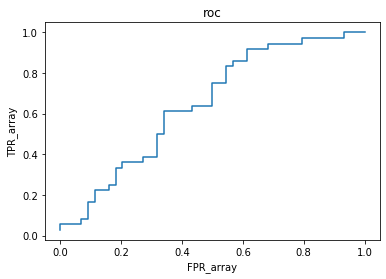

0.6483585858585861


In [0]:
#计算AUC面积
def cal_rate(result, thres):
    all_number = len(result[0])
    # print all_number
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for item in range(all_number):
        disease = result[0][item]
        if disease >= thres:
            disease = 1
        if disease == 1:
            if result[1][item] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if result[1][item] == 0:
                TN += 1
            else:
                FN += 1
    # print TP+FP+TN+FN
    accracy = float(TP+FP) / float(all_number)
    if TP+FP == 0:
        precision = 0
    else:
        precision = float(TP) / float(TP+FP)
    TPR = float(TP) / float(TP+FN)
    TNR = float(TN) / float(FP+TN)
    FNR = float(FN) / float(TP+FN)
    FPR = float(FP) / float(FP+TN)
    # print accracy, precision, TPR, TNR, FNR, FPR
    return accracy, precision, TPR, TNR, FNR, FPR


#prob是样本正确率的array，label则是样本label的array

threshold_vaule = sorted(prob)
threshold_num = len(threshold_vaule)
accracy_array = np.zeros(threshold_num)
precision_array = np.zeros(threshold_num)
TPR_array = np.zeros(threshold_num)
TNR_array = np.zeros(threshold_num)
FNR_array = np.zeros(threshold_num)
FPR_array = np.zeros(threshold_num)
# calculate all the rates

for thres in range(threshold_num):
    accracy, precision, TPR, TNR, FNR, FPR = cal_rate((prob,1-label), threshold_vaule[thres])
    accracy_array[thres] = accracy
    precision_array[thres] = precision
    TPR_array[thres] = TPR
    TNR_array[thres] = TNR
    FNR_array[thres] = FNR
    FPR_array[thres] = FPR

AUC = np.trapz(TPR_array, FPR_array)
threshold = np.argmin(abs(FNR_array - FPR_array))
EER = (FNR_array[threshold]+FPR_array[threshold])/2
plt.plot(FPR_array, TPR_array)
plt.title('roc')
plt.xlabel('FPR_array')
plt.ylabel('TPR_array')
plt.show()
print(-AUC)

In [0]:
!nvidia-smi

Wed Dec 25 15:57:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    46W / 250W |  12705MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  